### Cylindrical Epithelium 

In this notebook, we illustrate the epithelium generation strategy.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt
import graph_tool.all as gt
import pandas as pd
import seaborn as sns

import IPython.display as disp


/home/guillaume/anaconda/envs/python3/lib/python3.4/site-packages/graph_tool/draw/cairo_draw.py:1318: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


In [3]:
import leg_joint

### `epithelium.generation` documentation

This module contains the elements necessary to build an epithelium.

vertex_data, cell_data, edge_data, junction_data and 
face_data are dictionnaries of the form:
```python
{'data_name': (default_value, data_type)}.
```
They are used to instanciate all the necessary property maps over the graph.

vertex_data and edge_data contain data unspecific to the vertex or edge type (here cell vertices, junction edges, and triangular faces). Specific data for cells and junction edges will be instanciated as PropertyMaps of the corresponding GraphView, except for faces. Note that graphviews inherits the parent graphs propertymaps at instanciation time.

It is recommanded to add new properties by specifying them here, although they can also be specified when Epithelium is instanciated. Adding properties dynamically is possible but can lead to inconsitencies between graphviews and the parent graph's propery maps.


#### Data structures specification

In [45]:
from leg_joint.epithelium.generation import (vertex_data,  cell_data,
                                             edge_data, junction_data,
                                             face_data)

Here is an example of data dictionnary for the graph vertices:

In [46]:
vertex_data

{'height': (0.0, 'float'),
 'is_active_vert': (1, 'bool'),
 'is_alive': (1, 'bool'),
 'is_cell_vert': (0, 'bool'),
 'rho': (0.0, 'float'),
 'theta': (0.0, 'float'),
 'x': (0.0, 'float'),
 'y': (0.0, 'float'),
 'z': (0.0, 'float')}

### Cell / junction vertex grids generation

In [47]:
from leg_joint.epithelium.generation import base_grid, cylindrical


In [48]:
print(base_grid.__doc__)


    Creates a 2D hexagonal grid with the following geometry:

             j   j

           j   c   j   c

             j   j

    Parameters
    ----------

    n_cells_x : int
        Number of cells along the first dimention
        (i.e the number of cell vertices on an axis
         parallel to the first dimention)

    n_cells_y : int
        Number of cells along the second dimention
        (i.e the number of cell vertices on an axis
         parallel to the 2nd dimention)

    delta_x : float, optional
        Spacing between the verticies along first axis,
        default 1
    delta_y : float, optional
        Spacing between the verticies along 2nd axis
        default 1

    Note
    ----

    the total number of vertices N_v is given by  (N_v = n_cells_x * n_cells_y * 3)
    The number of _cell_ verices is n_cells_x * n_cells_y.

    Returns
    -------

    pos: np.ndarray
        Two dimentional array with shape `(N_v, 2)` with the vertex positions
    is_cell_vert: n

In [49]:

### Typical number of cells along z
n_length = 5
### Typical number of cells around the cylinder
n_circum = 7

### Distance between 2 vertices
l_0 = 1. 
### heights
h_0 = 1.


### Compute the cylinder radius from the number of vertices
rho_c = n_circum * l_0 / (2 * np.pi)
### Compute the lumen radius from the prefered height
rho_lumen = rho_c - h_0

delta_theta = 2 * np.pi / n_circum
delta_z = delta_theta * rho_c * np.sqrt(3)/2.

ztheta_pos, is_cell_vert = base_grid(n_length, n_circum,
                                     delta_z, delta_theta)

fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(ztheta_pos[:, 0] * rho_c,
           ztheta_pos[:, 1],
           c=is_cell_vert, s=100)

ax.scatter(ztheta_pos[:, 0][is_cell_vert] * rho_c,
           ztheta_pos[:, 1][is_cell_vert],
           c='b', s=100)


ax.set_aspect('equal')
ax.set_xlabel('Proximal - Distal')
ax.set_ylabel('Circumferential')


In [50]:
graph = cylindrical(n_length, n_circum, l_0=1, h_0=1)


2015-05-18 16:26:19,125 -leg_joint.epithelium.generation -reorient_edges -- INFO -filpped 90 edges


In [51]:
graph.vp['is_cell_vert'].a[:3]

PropertyArray([1, 0, 0], dtype=uint8)

In [52]:
graph.ep['is_junction_edge'].a[:3]

PropertyArray([1, 1, 1], dtype=uint8)

In [53]:
def draw(graph, coords):
    is_cell_vert = graph.vp['is_cell_vert']
    is_junction_edge = graph.ep['is_junction_edge']
    pos_vp = gt.group_vector_property([graph.vp[c] for c in coords])
    
    not_junction = is_junction_edge.copy()
    not_junction.a = 1 - is_junction_edge.a
    gt.graph_draw(graph, pos_vp, inline=True,
                  vertex_fill_color=is_cell_vert,
                  edge_color=not_junction,
                  output_size=(600, 300))

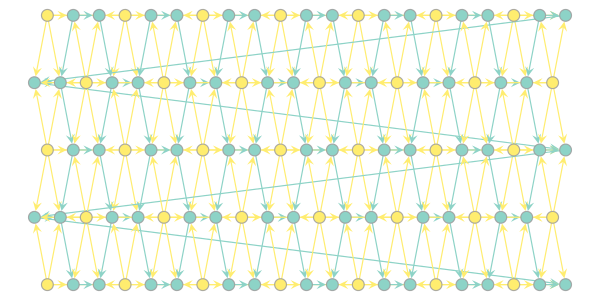

In [54]:
graph.vp['sigma'] = graph.vp['x'].copy()
#graph.vp['sigma'].a = np.arctan2(graph.vp['y'].a, graph.vp['x'].a) * rho_c 
graph.vp['sigma'].a = graph.vp['theta'].a * rho_c 

draw(graph, ['sigma', 'z'])

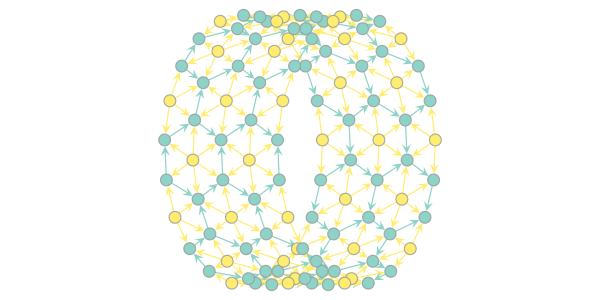

In [56]:

z_angle = np.pi/5
d_theta = 0


graph.vp['psd_x'] = graph.vp['x'].copy()
graph.vp['psd_y'] = graph.vp['y'].copy()
pseudo_x = graph.vp['psd_x']
pseudo_y = graph.vp['psd_y']
graph.vp['rho'].a = np.hypot(graph.vp['x'].a,
                             graph.vp['y'].a)


pseudo_x.a = graph.vp['z'].a * np.cos(z_angle) - graph.vp['rho'].a * np.sin(
        graph.vp['theta'].a + d_theta) * np.sin(z_angle)
pseudo_y.a = graph.vp['rho'].a * np.cos(graph.vp['theta'].a + d_theta)

draw(graph, ['psd_x', 'psd_y'])



In [77]:
graph.set_edge_filter(graph.ep['is_junction_edge'], inverted=True)
degrees = np.bincount(graph.degree_property_map('out').fa)
graph.clear_filters()

assert degrees[0] == graph.num_vertices() - degrees[4] - degrees[6]

assert degrees[4] == 2 * n_circum
assert degrees[6] == (n_length - 2) * n_circum




In [58]:
graph.vp.keys()

dict_keys(['height', 'y', 'is_alive', 'is_cell_vert', 'rho', 'x', 'sigma', 'theta', 'is_active_vert', 'psd_y', 'psd_x', 'z'])

In [68]:
degrees

array([70,  0,  0,  0, 14,  0, 21])

In [69]:
n_circum

7

In [70]:
(n_length - 2) * n_circum

21

In [73]:
n_length

5

In [75]:
graph.num_vertices()

105